In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

## Noise Pattern Generation

In the previous chapter, we have use one dimensional noise to generate visually pleasant functions. Here we'll cover the 2D application of the noise to combine the previous patterns into the generation of new images with noise textures.

At the end of the notebook, we'll build a small framework for blending images with different configurations. And finally, we'll apply them to a 3D model.  We need basic utilities:

In [ ]:
class Vec2 ():

    def __init__(self, x, y):

        self.x = x
        self.y = y

    def __mul__(self, other):

        self.x *= other
        self.y *= other

        return self

    def __str__(self) -> str:

        return str(self.x)+ ' ' + str(self.y)


In [ ]:
def lerp (a: float, b: float, t: float) -> float: return (1 - t) * a + t * b

In [ ]:
def lerp_norm(t: float) -> float: return lerp(0.0, 1.0, t)

In [ ]:
def smoothstep (t : float ) -> float : return t * t * (3 - 2 * t)

### Value Noise

The two-dimensional representation is again build based on simple lerp functions. The difference is that in this new case, we need to use the lerp within a grid. The following plots represent the grid the noise uses and how each point is going to be calculated bases on the distances to the cell it is located.

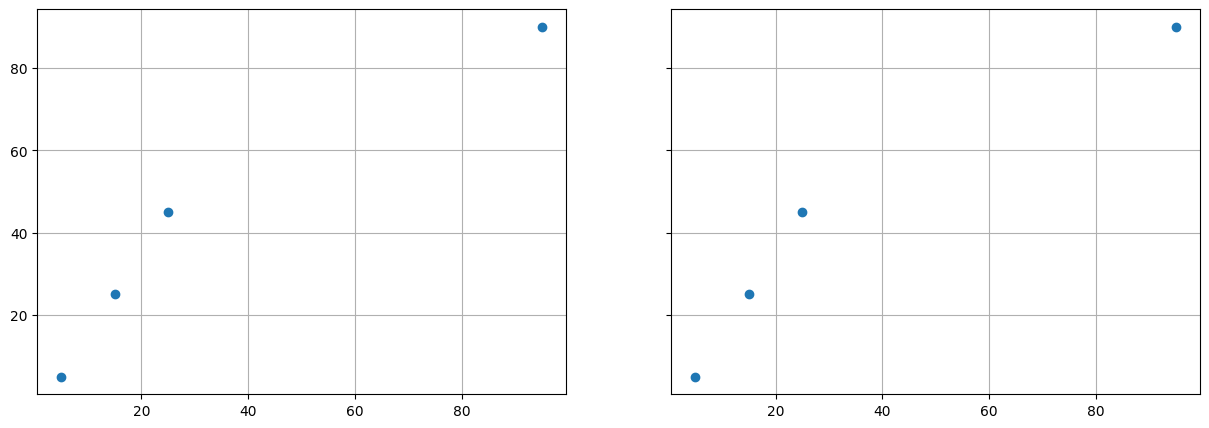

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

points = [
    (5, 5),
    (15, 25),
    (25, 45),
    (95, 90),
]

x1 = list(map(lambda x: x[0], points))
y1 = list(map(lambda x: x[1], points))

x2 = list(map(lambda x: x[0], points))
y2 = list(map(lambda x: x[1], points))

ax1.scatter(x1, y1)
ax2.scatter(x2, y2)

for ax in fig.get_axes():

    ax.label_outer()
    ax.grid(True)

As you can see in the plots, the point is surrounded by the four vertices of a cell. We will use the basic interpolation function to find a value for that point by linearly interpolating the values from the cell corners that surround the point to evaluate.

We can decide the size of the grid, in this case 256 by default on each side. And again, we design the code to take the interpolation function as a parameter, in the first section we wrote some of the function utilities that we need to keep using.

In [ ]:
import math
import random

class ValueNoise ():

    def __init__ (self, kMaxTableSize, kMaxTableSizeMask, kMaxVerticesMask, seed = 1984) :

        # constructor based:
        self.kMaxTableSize = kMaxTableSize
        self.kMaxTableSizeMask = kMaxTableSizeMask
        self.kMaxVerticesMask = kMaxVerticesMask

        self.r = []

        # create an array of random values
        for k in range (kMaxTableSize * kMaxTableSize) :

            self.r.append(random.uniform(0.0, 1.0))

    def eval(self, p : Vec2) :

        xi = math.floor(p.x)
        yi = math.floor(p.y)

        tx = p.x - xi
        ty = p.y - yi

        rx0 = xi & self.kMaxTableSizeMask
        rx1 = (rx0 + 1) & self.kMaxTableSizeMask
        ry0 = yi & self.kMaxTableSizeMask
        ry1 = (ry0 + 1) & self.kMaxTableSizeMask

        c00 = self.r[ry0 * self.kMaxVerticesMask + rx0]
        c10 = self.r[ry0 * self.kMaxVerticesMask + rx1]
        c01 = self.r[ry1 * self.kMaxVerticesMask + rx0]
        c11 = self.r[ry1 * self.kMaxVerticesMask + rx1]

        sx = smoothstep(tx)
        sy = smoothstep(ty)

        nx0 = lerp(c00, c10, sx)
        nx1 = lerp(c01, c11, sx)

        return lerp(nx0, nx1, sy)

### Surfer Visualizer

In [ ]:
class Surfer ():

    def __init__(self, noise, imageWidth = 512, imageHeight = 512):

        self.noise = noise
        self.imageWidth = imageWidth
        self.imageHeight = imageHeight

        # pre computed:
        self.invImageWidth  = 1. / imageWidth
        self.invImageHeight = 1. / imageHeight
        self.noiseFrequency = 5

    def start(self):

        # init with 0s:

        self.noiseMap = [ [0]*self.imageWidth for i in range(self.imageHeight) ]

    def surf(self):

        # init emtpy aray:
        noiseMap = [ [0]*self.imageWidth for i in range(self.imageHeight) ]

        frequency = 0.05

        for j in range(self.imageHeight) :

            for i in range(self.imageWidth) :

                # generate a float in the range [0:1]

                p = Vec2(i * self.invImageWidth, j * self.invImageHeight) * self.noiseFrequency

                noiseMap[i][j] = self.noise.eval(p)

                # noiseMap[i][j] = self.noise.eval(Vec2(i, j) * frequency);

        return noiseMap

In [ ]:
noise_1 = ValueNoise(256, 255, 10)
noise_2 = ValueNoise(128, 127, 11)
noise_3 = ValueNoise(64, 63, 15)

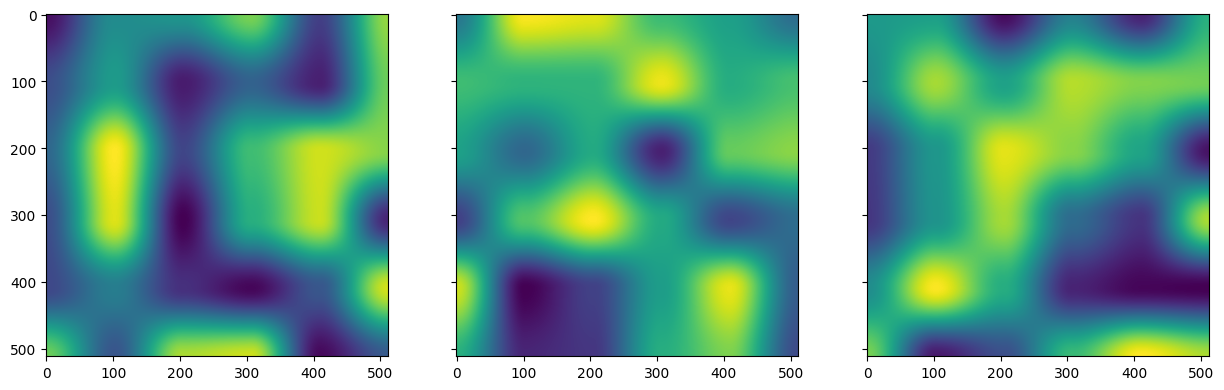

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

s_1 = Surfer(noise_1)
s_2 = Surfer(noise_2)
s_3 = Surfer(noise_3)

ax1.imshow(s_1.surf())
ax2.imshow(s_2.surf())
ax3.imshow(s_3.surf())

for ax in fig.get_axes():

    ax.label_outer()


Like we discuss earlier, we can use layers to achieve more detail and organic effects...

In [ ]:
class FractSurfer ():

    def __init__ (self, noise, frequency, numLayers=5, imageWidth = 512, imageHeight = 512) :

        self.noise = noise
        self.imageWidth = imageWidth
        self.imageHeight = imageHeight
        self.frequency = frequency
        self.numLayers = numLayers

    def surf(self) :

        maxNoiseVal = 0

        noiseMap = [ [0]*self.imageWidth for i in range(self.imageHeight) ]

        for j in range(self.imageHeight) :

            for i in range(self.imageWidth) :

                pNoise = Vec2(i, j) * self.frequency
                amplitude = 1

                for l in range(self.numLayers) :

                    noiseMap[i][j] += self.noise.eval(pNoise) * 2;
                    pNoise *= 2
                    amplitude *= 0.5

                if (noiseMap[i][j] > maxNoiseVal) :
                    maxNoiseVal = noiseMap[i][j]

        return noiseMap


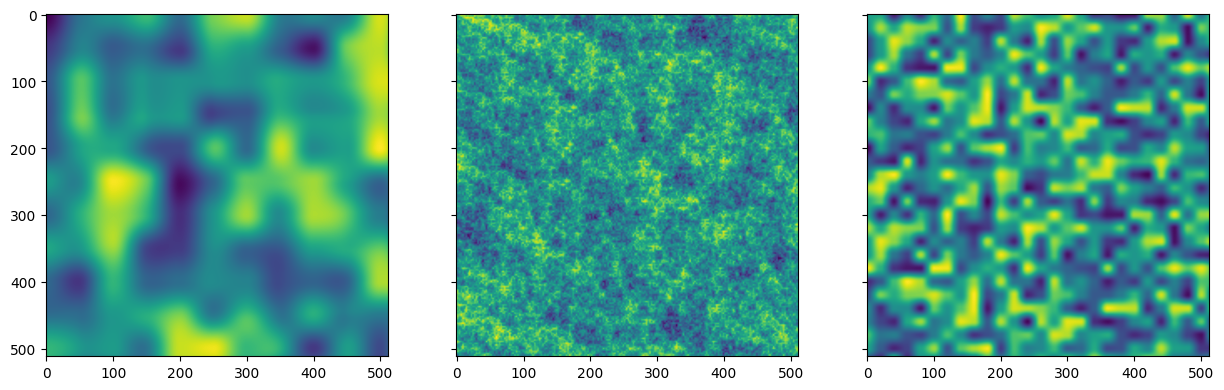

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

s_1 = FractSurfer(noise_1, frequency=0.01, numLayers=2)
s_2 = FractSurfer(noise_2, frequency=0.025, numLayers=5)
s_3 = FractSurfer(noise_3, frequency=0.05, numLayers=1)

ax1.imshow(s_1.surf())
ax2.imshow(s_2.surf())
ax3.imshow(s_3.surf())

for ax in fig.get_axes():

    ax.label_outer()
    ax.grid(False)


## Compositional Pattern Producing Networks

There are many techniques for content generation, we have seen a few noise algorithms and some of their applications. The rest of the notebook introduces us into deep learning techniques for content generation through Compositional Pattern Producing Networks, CPPNs.

CPPN, are a kind of artificial neural network, however they differ in the way they are used. Artificial neural networks, such as convolutional neural networks, are used for classification or in more general terms for making predictions from data. CPPNs are used as generators of life-like patterns. What the network is going to do is take a discrete 2D vector field (mesh grid) and map it to the 3D space of colors.

$$ f: {\Bbb R}^2 \to {\Bbb R}^3 $$

Along the notebook, we'll cover how this networks can be used to render image patterns. Since the network would not be trained, the output would depend on the random initialization of all the constructor parameters. Then, the neural network is a continuous function acting as a fragment shader (like [Shadertoy's](https://www.shadertoy.com/profile/?show=shaders)), taking in the UV coordinates of the image pixels and mapping them to colors.

$$f(u, v) = \sigma(...W_2 a(W_1 \vec{uv} + b_1) + b_2...)$$

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

from base64 import b64encode

from IPython.display import Image
from IPython.display import HTML

### FFN

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import activations

In [ ]:
# how layers are used and how to use activation functions to draw different patterns:

In [ ]:
class FFN():

    def __init__(self, width, depth, out_size=1):

        self.layers = []
        self.mirror = False

        # dense layer:
        def dense(size, activation):

          return tf.keras.layers.Dense(

              size,
              activation=activation,
              kernel_initializer=tf.random_normal_initializer(0, 1),
              bias_initializer=tf.random_normal_initializer(0, 1)
          )

        for i in range(depth):

            # sigmoid for first layer:
            if (i == 0):
              self.layers.append(dense(width, tf.sigmoid))
            else:
              self.layers.append(dense(width, tf.keras.activations.tanh))

        # map to pixels
        self.layers.append(dense(out_size, tf.sigmoid))

    def input_mesh(self, size):

        w, h = size
        ar = w / h

        x = np.linspace(-ar / 2, ar / 2, w)
        y = np.linspace(-0.5, 0.5, h)

        if self.mirror:
          x = np.abs(x)
          y = np.abs(y)

        xx, yy = np.meshgrid(x, y)

        mesh = np.stack((xx.reshape(-1), yy.reshape(-1)), axis=-1)

        return mesh

    def generate(self, z, im_size=(128, 128)):

        # need the imput mesh
        mesh = self.input_mesh(im_size)

        # Add z to input
        result = np.concatenate((np.tile(z, (mesh.shape[0], 1)), mesh), axis=-1)

        # apply the layers to it:
        for d in self.layers:
            result = d(result)

        img = result.numpy().reshape(*im_size[::-1], -1)

        return img if img.shape[-1] != 1 else img[:,:,0]


neurogram description:

In [ ]:
class Sampler():

  """ This class makes plotting functionalities easier """

  def __init__(self, ppn_ctor, cols, rows):

    """ take the CPPN constructor and initialize with some changing params """

    # Save the networks

    self.cppns = []
    self.cols = cols
    self.rows = rows

    for r in range(rows):

        self.cppns.append([])

        for c in range(cols):

            self.cppns[-1].append(ppn_ctor(r,c))

  # algorithm for increasing the params:

  def sample(self, z, w, h):

    """ draw different images and concatenate them """

    rows_of_images = []

    for r in range(self.rows):

        row_of_images = []

        for c in range(self.cols):

            img = self.cppns[r][c].generate(z, im_size=(w // self.cols, h // self.rows))

            row_of_images.append(img)

        row = np.concatenate(row_of_images, axis=1)

        rows_of_images.append(row)

    return np.concatenate(rows_of_images, axis=0)

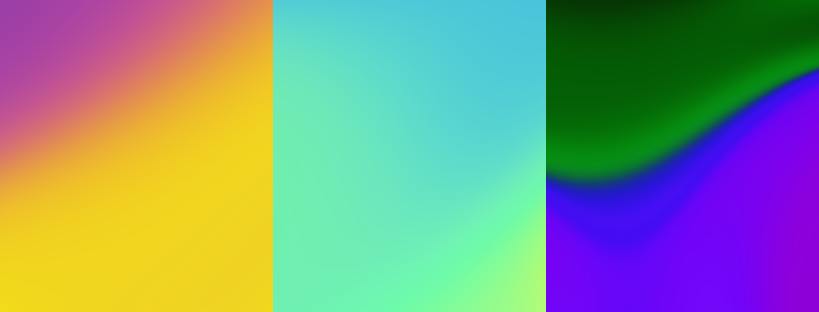

In [ ]:
imgs = Sampler(lambda r, c: FFN(10+r, 8+c, 3), 3, 1).sample(z=1, w=820, h=312)

plt.imsave('test.png', imgs, format='png', cmap='binary')

Image(filename='test.png')

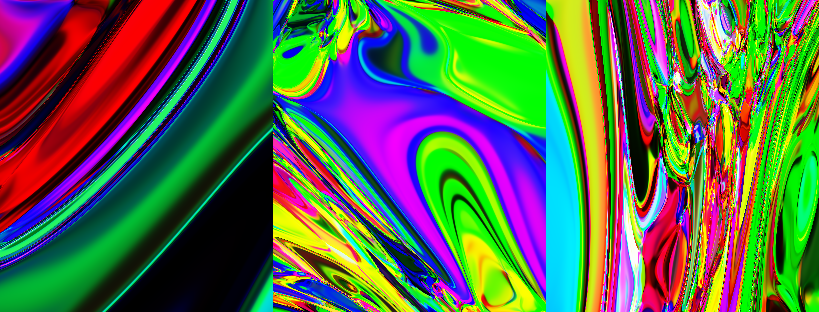

In [ ]:
imgs = Sampler(lambda r, c: FFN(25+r, 15+c, 3), 3, 1).sample(z=1, w=820, h=312)

plt.imsave('test.png', imgs, format='png', cmap='binary')

Image(filename='test.png')

## Filter Pipeline

Along the notebook we've covered the generation of noise patterns and the use of CPPN's for visualizing the network latent space and mapping it to a color space. In this last section we are building a collection of classes for making operations on images such as blending them and applying masks.

Our focus is to make a final result that generates a new pattern based on the previous constructions. In some way we're using filters to link different effects and combine them based on some heuristic rules.

In [ ]:
class Node ():

  def __init__(self, img):

    self.img = img

  def process (self):

    """ image processing behaviour """

    return self.img

In [ ]:
class Neurogram (Node):

  """ crates a neurogram based on the FFN """

  def __init__ (self, FFN):

    self.ffn = FFN

  def process (self):

      a = self.ffn.generate(1, im_size=(512, 512))

      # transform into 255 image:
      from PIL import Image
      s = np.array(a)*255
      imge_out = Image.fromarray(s)
      img_as_img = imge_out.convert("RGB")

      return np.array(img_as_img)

In [ ]:
class Noiser (Node):

  """ encapsulates noise creation and surfs it """

  def __init__(self, noise):

    self.noise = noise

  def process (self):

    s_l = Surfer(self.noise, imageWidth=512, imageHeight=512)

    # clean up
    from PIL import Image
    s = np.array(s_l.surf())*255
    imge_out = Image.fromarray(s)
    img_as_img = imge_out.convert("RGB")

    return np.array(img_as_img)

In [ ]:
class Threshold (Node):

  def __init__(self, node, threshold):

    self.node = node

    self.threshold = threshold

  def process(self):

    """ returns an image """

    img = self.node.process()

    imagegray = img

    assignvalue = 255 

    threshold_method = cv2.THRESH_BINARY

    _, result = cv2.threshold(imagegray, self.threshold, assignvalue, threshold_method)

    return result

In [ ]:
class Function1P (Node):

  def __init__(self, node):

    self.node = node

  def process(self, function):

    img1 = self.node.process()

    return function(img1)


In [ ]:
class Function (Node):

  def __init__(self, node_1, node_2):

    self.node_1 = node_1
    self.node_2 = node_2

  def process(self, function):

    img1 = self.node_1.process()
    img2 = self.node_2.process()

    """ operation for bitwise images """

    return function(img1, img2)

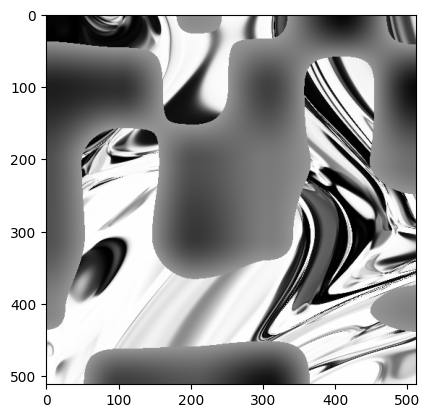

In [ ]:
p0 = Noiser(ValueNoise(256, 255, 10))

p1 = Neurogram(FFN(25, 15, 1))

n1 = Threshold(p0, 150)

f1 = Function(~n1.process())

r1 = cv2.bitwise_or(~n1.process(),p1.process())

r0 = cv2.bitwise_or(n1.process(),p0.process())

r = cv2.bitwise_and(r0,r1)

plt.imshow(r)